In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, auc
from sklearn import grid_search
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

/Users/kaylatorres/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kaylatorres/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_csv('NFLPlaybyPlay2015.csv')
data.columns

/Users/kaylatorres/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'Unnamed: 0', u'Date', u'GameID', u'Drive', u'qtr', u'down', u'time',
       u'TimeUnder', u'TimeSecs', u'PlayTimeDiff', u'SideofField', u'yrdln',
       u'yrdline100', u'ydstogo', u'ydsnet', u'GoalToGo', u'FirstDown',
       u'posteam', u'DefensiveTeam', u'desc', u'PlayAttempted',
       u'Yards.Gained', u'sp', u'Touchdown', u'ExPointResult', u'TwoPointConv',
       u'DefTwoPoint', u'Safety', u'PuntResult', u'PlayType', u'Passer',
       u'PassAttempt', u'PassOutcome', u'PassLength', u'PassLocation',
       u'InterceptionThrown', u'Interceptor', u'Rusher', u'RushAttempt',
       u'RunLocation', u'RunGap', u'Receiver', u'Reception', u'ReturnResult',
       u'Returner', u'BlockingPlayer', u'Tackler1', u'Tackler2',
       u'FieldGoalResult', u'FieldGoalDistance', u'Fumble', u'RecFumbTeam',
       u'RecFumbPlayer', u'Sack', u'Challenge.Replay', u'ChalReplayResult',
       u'Accepted.Penalty', u'PenalizedTeam', u'PenaltyType',
       u'PenalizedPlayer', u'Penalty.Yards', u'PosTeamS

In [3]:
data['PlayType_lag'] = data['PlayType']
data.PlayType_lag = data.PlayType_lag.shift(+1)
data['ydsnet_lag'] = data['ydsnet']
data.ydsnet_lag = data.ydsnet_lag.shift(+1)
data['ScoreDiff_lag'] = data['ScoreDiff']
data.ScoreDiff_lag = data.ScoreDiff_lag.shift(+1)

In [ ]:
def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0
    return result

mask = data.groupby(['GameID'])['GameID'].transform(mask_first).astype(bool)
data1 = data.loc[mask]
data1.drop(data1.index[len(data1)-1])


In [ ]:
#only want to use downs 1-3 

downs = [1,2,3]
 #find the downs in the down column, don't use fourth down because can be 
    #unpredictable and don't know if players will run it or kick
data1 = data1[data1['down'].isin(downs)]

#using only certain plays to predict what the offense will do.
#plays like no play, knee, illegal formation do not help to predict this
used_plays = ['Run', 'Pass']
#find only these plays in the play type column
data1 = data1[data1['PlayType'].isin(used_plays)]

#want to create a binary classification of what the play type is
#0 for run and 1 for pass/sack

data1['play'] = data1.PlayType.apply(lambda x: 1 if x == "Pass" else 0)

#these features are the features I will use to predict whether there will
#be a sack, run, or pass
data1 = data1[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'PosTeamScore', 'ScoreDiff','DefTeamScore','Drive','play','PlayType_lag','ydsnet_lag']]



In [ ]:
data_play = pd.get_dummies(data1['PlayType_lag'])

In [ ]:
data1 = pd.concat([data1,data_play],axis =1)
data1

In [ ]:
data1.dtypes

In [ ]:
random_state = 18
train, test = train_test_split(data1, test_size = 0.33)

In [ ]:
train_X = train[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'PosTeamScore', 'ScoreDiff','DefTeamScore','Drive','ydsnet_lag','End of Game','Extra Point', 'Field Goal', 'Kickoff', 'No Play','Onside Kick','Pass','Punt','QB Kneel','Quarter End','Run','Sack','Spike','Timeout','Two Minute Warning']]
train_y = train[['play']]
test_X = test[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'PosTeamScore', 'ScoreDiff','DefTeamScore','Drive','ydsnet_lag','End of Game','Extra Point', 'Field Goal', 'Kickoff', 'No Play','Onside Kick','Pass','Punt','QB Kneel','Quarter End','Run','Sack','Spike','Timeout','Two Minute Warning']]
test_y = test[['play']]

In [ ]:
train_X

In [ ]:
clf = RandomForestRegressor(n_jobs = -1, oob_score = True, n_estimators = 100, min_samples_leaf = 12, max_features =.8)

In [ ]:
clf.fit(train_X,train_y)

In [ ]:
preds = clf.predict(test_X)
peep = clf.oob_prediction_
peep

In [ ]:
clf.score(test_X,test_y)

In [ ]:
print("roc score area", roc_auc_score(train_y,peep))

In [ ]:
#most important features for predicting whether a player will pass/Sack or 
#run on the next play
x = range(train_X.shape[1])
sns.barplot(x = clf.feature_importances_, y = train_X.columns,palette="Blues_d")
sns.despine(left=True, bottom=True)

In [ ]:
#clear output again to run this model 

In [4]:
def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0
    return result

mask = data.groupby(['GameID'])['GameID'].transform(mask_first).astype(bool)
data2 = data.loc[mask]
data2.drop(data2.index[len(data2)-1])


,Unnamed: 0,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,...,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,Season,PlayType_lag,ydsnet_lag,ScoreDiff_lag
1,51.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,15:00,15.0,3600.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Kickoff,0.0,0.0
2,72.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,14:21,15.0,3561.0,39.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Run,18.0,0.0
3,101.0,9/10/2015,2.015091e+09,1.0,1.0,2.0,14:04,15.0,3544.0,17.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Pass,31.0,0.0
4,122.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,13:26,14.0,3506.0,38.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Run,31.0,0.0
5,159.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,12:42,13.0,3462.0,44.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Pass,45.0,0.0
6,180.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,12:05,13.0,3425.0,37.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Run,56.0,0.0
7,199.0,9/10/2015,2.015091e+09,1.0,1.0,2.0,11:20,12.0,3380.0,45.0,...,M.Gilbert,10.0,0.0,0.0,0.0,0.0,2015.0,Sack,48.0,0.0
8,236.0,9/10/2015,2.015091e+09,1.0,1.0,2.0,10:53,11.0,3353.0,27.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,No Play,54.0,0.0
9,261.0,9/10/2015,2.015091e+09,1.0,1.0,3.0,10:28,11.0,3328.0,25.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Run,54.0,0.0
10,285.0,9/10/2015,2.015091e+09,1.0,1.0,4.0,9:44,10.0,3284.0,44.0,...,NaN,0.0,0.0,0.0,0.0,0.0,2015.0,Pass,54.0,0.0


In [5]:
downs = [1,2,3]
 #find the downs in the down column, don't use fourth down because can be 
    #unpredictable and don't know if players will run it or kick
data2 = data2[data2['down'].isin(downs)]

type_pass = ['Short','Deep']
 #only get the data rows that have passes that are either deep or short
data2 = data2[data2['PassLength'].isin(type_pass)]

#make throw equal 1 if the pass is short and 0 if it is deep
data2['throw'] = data2.PassLength.apply(lambda x: 1 if x == "Short" else 0)

data2 = data2[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'ydsnet_lag','ScoreDiff_lag','Drive','throw']]


In [6]:
data2 = data2[np.isfinite(data2['ScoreDiff_lag'])]


In [7]:
train_2, test_2 = train_test_split(data2, test_size = 0.33)

In [8]:
train_Xa = train_2[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'ydsnet_lag', 'ScoreDiff_lag','Drive']]
train_ya = train_2[['throw']]
test_Xa = test_2[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'ydsnet_lag', 'ScoreDiff_lag','Drive']]
test_ya = test_2[['throw']]

In [9]:
clf = RandomForestRegressor(n_jobs = -1, oob_score = True, n_estimators = 100, min_samples_leaf = 12, max_features =.8)

In [10]:
clf.fit(train_Xa,train_ya)

/Users/kaylatorres/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=12, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [11]:
pred = clf.predict(test_Xa)
probas = clf.oob_prediction_
pred

array([ 0.84151226,  0.78776113,  0.88009479, ...,  0.69249377,
        0.80429606,  0.70886571])

In [12]:
clf.score(test_Xa,test_ya)

0.011921932072201713

In [13]:
print("roc score area", roc_auc_score(train_ya,probas))

('roc score area', 0.58103767629132586)


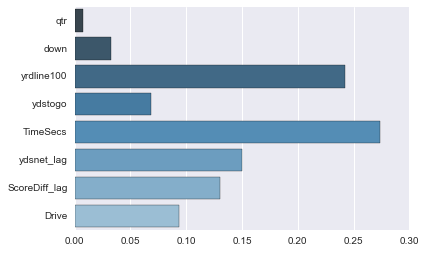

In [14]:
xa = range(train_Xa.shape[1])
sns.barplot(x = clf.feature_importances_, y = train_Xa.columns,palette="Blues_d")
sns.despine(left=True, bottom=True)

In [ ]:
#train_Xa = train_2[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'ydsnet', 'PosTeamScore', 'ScoreDiff','DefTeamScore','Drive']]
#train_ya = train_2[['throw']]
#test_Xa = test_2[['qtr', 'down', 'yrdline100','ydstogo', 'TimeSecs', 'ydsnet', 'PosTeamScore', 'ScoreDiff','DefTeamScore','Drive']]
#test_ya = test_2[['throw']]

data.dropna()
X = data[['qtr', 'down', 'yrdline100','ydstogo', 'ydsnet', 'PosTeamScore', 'ScoreDiff','DefTeamScore','Drive']]
y = data[['throw']]


    
train_Xa = X[0:12634].values
test_Xa = X[X > 12634].values
train_ya = y[0:12634].values
test_ya = y[y > 12634].values


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
 
# shuffle and split training and test sets
clf = GaussianNB()
#clf = RandomForestRegressor(n_jobs = -1, oob_score = True, n_estimators = 100, min_samples_leaf = 12, max_features =.8)
clf.fit(train_Xa, train_ya)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(test_ya, clf.predict_proba(test_Xa)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print clf.predict_proba(test_Xa)

In [ ]:
probas = clf.oob_prediction_(test_Xa) #[:,1]  
fpr, tpr, thresholds = metrics.roc_curve(test_ya, probas)
roc_auc = metrics.auc(fpr, tpr)
    
print("Area under the ROC %s curve : %f" % ('RandomForest', roc_auc))
    
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()